In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import numpy as np
import matplotlib.pyplot as plt

from helpr.physics.api import CrackEvolutionAnalysis
from helpr.physics.pipe import Pipe
from helpr.physics.crack_initiation import DefectSpecification
from helpr.physics.environment import EnvironmentSpecification
from helpr.physics.material import MaterialSpecification
from helpr.physics.stress_state import InternalAxialHoopStress
from helpr.physics.cycle_evolution import CycleEvolution
from helpr.physics.crack_growth import CrackGrowth, get_design_curve

from helpr.utilities.unit_conversion import convert_psi_to_mpa, convert_in_to_m
from helpr.utilities.plots import generate_pipe_life_assessment_plot
from helpr.utilities.postprocessing import calc_pipe_life_criteria, report_single_pipe_life_criteria_results, report_single_cycle_evolution

from probabilistic.capabilities.uncertainty_definitions import DeterministicCharacterization

## **Single Deterministic Pipeline Lifetime Evaluation**

####  **Problem Specification**

- **Geometry**

In [40]:
pipe_outer_diameter = convert_in_to_m(36)  # 36 inch outer diameter
wall_thickness = convert_in_to_m(0.406)    # 0.406 inch wall thickness

- **Material Properties**

In [41]:
yield_strength = convert_psi_to_mpa(52_000)      # material yield strength of 52_000 psi
fracture_resistance = 55                     # fracture resistance (toughness) MPa m1/2

- **Operating Conditions**

In [42]:
max_pressure = convert_psi_to_mpa(850)   # maximum pressure during oscillation MPa
min_pressure = convert_psi_to_mpa(638)   # minimum pressure during oscillation (or R = 0.75)
temperature = 293                         # K -> temperature of gas degrees C
volume_fraction_h2 = 1                      # % mole fraction H2 in natural gas blend

- **Initial Crack Dimensions**

In [43]:
flaw_depth = 25      # flaw 5% through pipe thickness
flaw_length = 0.04   # width of initial crack/flaw, m

####  **Modular Analysis**

- **Create Pipe Object**

In [44]:
pipe_module = Pipe(outer_diameter=pipe_outer_diameter,
                   wall_thickness=wall_thickness)

- **Specify Pipe Material Properties**

In [45]:
material_module = MaterialSpecification(yield_strength=yield_strength,
                                        fracture_resistance=fracture_resistance)

- **Specify Defect**

In [46]:
defect_module = DefectSpecification(flaw_depth=flaw_depth,
                                    flaw_length=flaw_length)

- **Specify Pipe Gaseous Environment**

In [47]:
environment_module = EnvironmentSpecification(max_pressure=max_pressure,
                                              min_pressure=min_pressure,
                                              temperature=temperature,
                                              volume_fraction_h2=volume_fraction_h2)

- **Determine Stress Environment on Pipe**

In [48]:
stress_module = InternalAxialHoopStress(pipe=pipe_module,
                                        environment=environment_module,
                                        material=material_module,
                                        defect=defect_module)

- **Specify Crack Growth Model**

In [49]:
crack_growth_module = CrackGrowth(environment=environment_module,
                                  growth_model_specification={'model_name': 'code_case_2938'})

- **Evolve Cracks Over Cycles to Failure**

In [50]:
pipe_evaluation = CycleEvolution(pipe=pipe_module,
                                 stress_state=stress_module,
                                 defect=defect_module,
                                 environment=environment_module,
                                 material=material_module,
                                 crack_growth_model=crack_growth_module)
load_cycling = pipe_evaluation.calc_life_assessment()

- **Postprocess QoIs** *(life criteria)*

In [51]:
life_criteria = calc_pipe_life_criteria(cycle_results=load_cycling,
                                        pipe=pipe_module,
                                        stress_state=stress_module)

- **Plot QoI**

              Cycles to a(crit)  Cycles to 25% a(crit)  Cycles to 1/2 Nc
Total cycles        4246.700789               1.000000       2123.350394
a/t                    0.330777               0.082694          0.270571


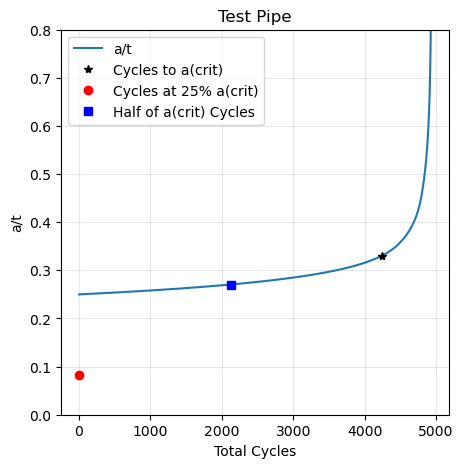

In [52]:
specific_life_criteria_result = report_single_pipe_life_criteria_results(life_criteria, pipe_index=0)
specific_load_cycling = report_single_cycle_evolution(load_cycling, pipe_index=0)
generate_pipe_life_assessment_plot(specific_load_cycling, specific_life_criteria_result, 'Test Pipe')
plt.savefig('./Figures/deterministic_crack_growth.png', format='png', dpi=300)

#### **Interact with Modular Analysis Through API**

- **Specify Problem, Initiate Crack, and Evolve Crack to Failure**

In [53]:
analysis = CrackEvolutionAnalysis(outer_diameter=DeterministicCharacterization(name='outer_diameter', value=pipe_outer_diameter),
                                  wall_thickness=DeterministicCharacterization(name='wall_thickness', value=wall_thickness),
                                  flaw_depth=DeterministicCharacterization(name='flaw_depth', value=flaw_depth),
                                  max_pressure=DeterministicCharacterization(name='max_pressure', value=max_pressure),
                                  min_pressure=DeterministicCharacterization(name='min_pressure', value=min_pressure),
                                  temperature=DeterministicCharacterization(name='temperature', value=temperature),
                                  volume_fraction_h2=DeterministicCharacterization(name='volume_fraction_h2', value=volume_fraction_h2),
                                  yield_strength=DeterministicCharacterization(name='yield_strength', value=yield_strength),
                                  fracture_resistance=DeterministicCharacterization(name='fracture_resistance', value=fracture_resistance),
                                  flaw_length=DeterministicCharacterization(name='flaw_length', value=flaw_length))
analysis.perform_study()

- **Postprocess and Plot QoI**

              Cycles to a(crit)  Cycles to 25% a(crit)  Cycles to 1/2 Nc
Total cycles        4246.700789               1.000000       2123.350394
a/t                    0.330777               0.082694          0.270571


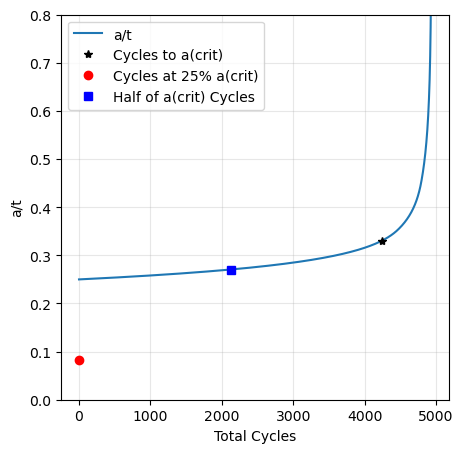

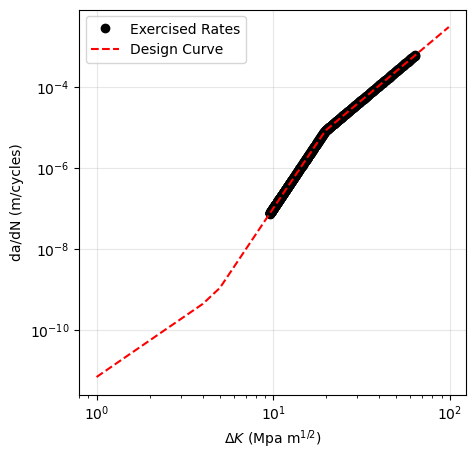

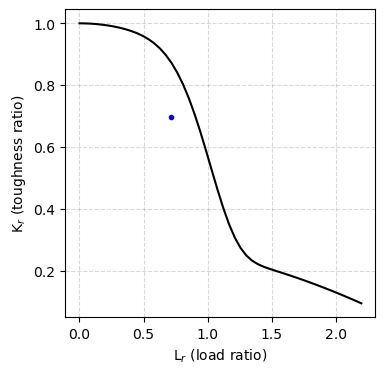

In [54]:
analysis.postprocess_single_crack_results()

dk, da_dn = get_design_curve(specified_r=0.75, specified_fugacity=0.16973535)
plt.plot(dk, da_dn, 'r--', zorder=2)
plt.legend(['Exercised Rates', 'Design Curve'], loc=0)
plt.savefig('./Figures/deterministic_crack_growth_rate.png', format='png', dpi=300)

analysis.assemble_failure_assessment_diagram()

In [55]:
analysis.save_results()

'Results/date_26_10_2023_time_10_25/'